In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
%matplotlib inline
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]
sns.set(font_scale=1.5)

In [4]:
totalDataDF = pd.read_csv('/projects/leelab3/psturm/concatData/totalDataDF.csv', header=0, index_col=0)

In [16]:
totalDataDF.tail()

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,1021204186,3451205016,4971205156,5371205166,1731204246,1321204196,4291205076,1081204186,651204176,2581204266
PCG,,,,,,,,,,,,,,,,,,,,,
BRAAK,0.500000,0.500000,1.000000,1.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,...,0.333333,0.166667,0.833333,0.833333,0.833333,0.666667,0.500000,0.666667,0.500000,0.833333
CERAD,1.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.666667,...,0.666667,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.666667,0.000000,0.666667
PLAQUES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.193955,0.000000,0.424560,0.549603,0.569194,0.000000,0.207878,0.306999,0.000000,0.192465
ABETA_IHC,0.466675,0.038185,0.004278,0.010662,0.033745,0.040946,0.010449,0.355101,0.132327,0.035876,...,0.200114,0.022805,0.244584,0.479285,0.022235,0.000000,0.214177,0.502471,0.000000,0.309768
TAU_IHC,0.096909,0.002176,0.000532,0.000806,0.510205,0.001087,0.001712,0.001887,0.012920,0.120113,...,0.000000,0.000000,0.047492,0.029338,0.038281,0.000000,0.001878,0.000102,0.000162,0.000638


In [6]:
binaryPathwayDF = pd.read_csv('/projects/leelab3/psturm/concatData/pathways.tsv', sep='\t', header=0)
binaryPathwayDF.set_index('Genes', inplace=True)

In [7]:
learnedV = np.load('/projects/leelab3/psturm/realModels/V.npy')

In [13]:
learnedV.shape

(16869, 356)

In [26]:
braakIndex = totalDataDF.index.get_loc('BRAAK')
ceradIndex = totalDataDF.index.get_loc('CERAD')
plaqIndex  = totalDataDF.index.get_loc('PLAQUES')
abetaIndex = totalDataDF.index.get_loc('ABETA_IHC')
tauIndex   = totalDataDF.index.get_loc('TAU_IHC')

In [28]:
learnedBraak = learnedV[braakIndex, :]
learnedCerad = learnedV[ceradIndex, :]
learnedPlaq  = learnedV[plaqIndex, :]
learnedAbeta = learnedV[abetaIndex, :]
learnedTau   = learnedV[tauIndex, :]

In [29]:
braakProjections = np.dot(learnedV, learnedBraak / np.linalg.norm(learnedBraak))
ceradProjections = np.dot(learnedV, learnedCerad / np.linalg.norm(learnedCerad))
plaqProjections  = np.dot(learnedV, learnedPlaq / np.linalg.norm(learnedPlaq))
abetaProjections = np.dot(learnedV, learnedAbeta / np.linalg.norm(learnedAbeta))
tauProjections   = np.dot(learnedV, learnedTau / np.linalg.norm(learnedTau))

In [20]:
pca_model = PCA(n_components=1)
transformedV = pca_model.fit_transform(learnedV - np.mean(learnedV, axis=0))

In [93]:
importanceGroup[6130:6140]

array(['genes', 'candi', 'genes', 'genes', 'genes', 'genes', 'genes',
       'genes', 'genes', 'genes'], dtype='<U5')

In [96]:
['0' if a % 2 else '1' for a in range(10)]

['1', '0', '1', '0', '1', '0', '1', '0', '1', '0']

In [111]:
identifiedIndices = GetTopGenes(learnedV, braakIndex)
identifiedGenes = totalDataDF.index.values[identifiedIndices]
importanceGroup = np.array(['candidate genes' if i in identifiedIndices[0:100] else 'genes' for i in range(len(identifiedIndices))])

In [112]:
projectionDF = pd.DataFrame({
    'Braak Score': braakProjections,
    'Cerad Score': ceradProjections,
    'Plaque Score': plaqProjections,
    'ABeta Score': abetaProjections,
    'Tau Score': tauProjections,
    'Pca First Dim': np.squeeze(transformedV),
    'Names': totalDataDF.index,
    'group': ['genes'] * 16864 + ['braak', 'cerad', 'plaques', 'abeta', 'tau'],
    'is_candidate': importanceGroup
})

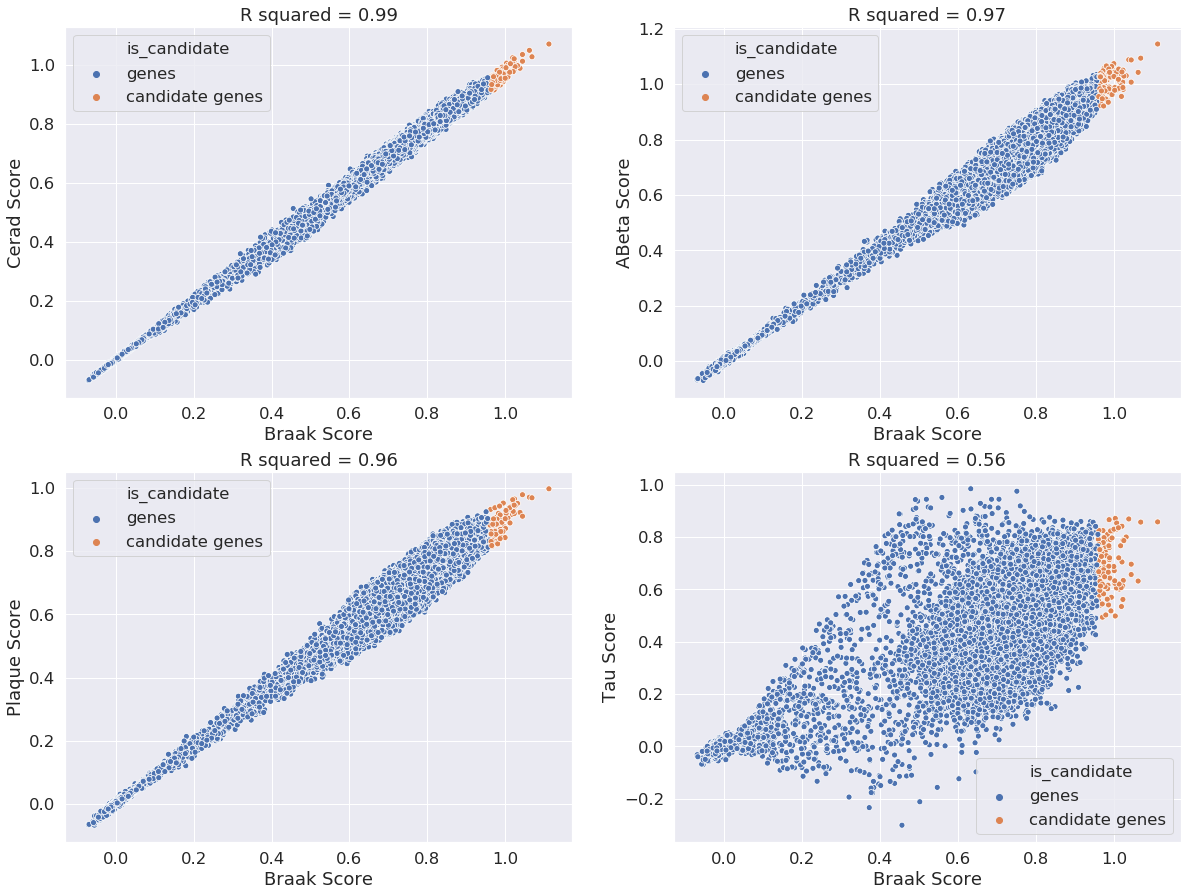

In [113]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
i = 0
for name in ['Cerad Score', 'Plaque Score', 'ABeta Score', 'Tau Score']:
    R, p = scipy.stats.pearsonr(projectionDF['Braak Score'].values, projectionDF[name].values)
    sns.scatterplot(x='Braak Score', y=name, data=projectionDF, hue='is_candidate', 
                    ax=axs[i % 2, int(i / 2)])
    axs[i % 2, int(i / 2)].set_title('R squared = {:.2f}'.format(R*R))
    i = i + 1

In [114]:
identifiedGenes[1:100]

array(['RASL10B', 'APOOL', 'OPRM1', 'CYP2S1', 'CCDC64', 'FOXG1',
       'SERPINB12', 'B3GNT8', 'PTK2B', 'ZNF311', 'FOXP3', 'CHRNG',
       'SLC17A7', 'RGN', 'MAGEC3', 'EMX1', 'CRYBB2', 'THNSL2', 'OPRD1',
       'UNC5A', 'KCNJ4', 'ISM1', 'CHRM1', 'FZD10', 'HTR1E', 'NAT1',
       'WNT4', 'GPR63', 'TBR1', 'GRIA3', 'CSMD1', 'LHX2', 'NEFL', 'DCST2',
       'ACRBP', 'PDE2A', 'DNM1', 'GABRB1', 'SYN1', 'GDA', 'LZTS1',
       'KALRN', 'NEUROD2', 'ST8SIA3', 'EFHB', 'TSPAN32', 'GJD2', 'LIPC',
       'DBH', 'CABP1', 'F10', 'BCL11A', 'SCN2A', 'NR0B1', 'CHMP4C',
       'DLGAP2', 'SLC22A13', 'SLC5A8', 'DRD5', 'MICAL2', 'KCNB2', 'CILP',
       'NTN3', 'OR2L13', 'PRKACA', 'KCNS1', 'CHN1', 'KCNQ5', 'NGF',
       'TRIL', 'CLDND2', 'IL1RAPL2', 'NRXN3', 'FAM71C', 'CCNA1', 'TNNT2',
       'DPT', 'PAQR9', 'ARMC12', 'LRRTM4', 'PCSK2', 'ZNF215', 'CATSPER3',
       'FDX1L', 'SIRPA', 'TEKT5', 'CD200R1', 'VSNL1', 'PPP3R2', 'CDH9',
       'HTR3B', 'GATA2', 'ABCG5', 'NPTX1', 'PCLO', 'SLC22A1', 'HIST1H2AK',
       '

In [115]:
binaryPathwayDF.head()

,REACTOME_GLYCOGEN_BREAKDOWN_GLYCOGENOLYSIS,REACTOME_TRANSLATION,REACTOME_PYRIMIDINE_CATABOLISM,REACTOME_RNA_POL_III_TRANSCRIPTION_INITIATION_FROM_TYPE_2_PROMOTER,REACTOME_INHIBITION_OF_THE_PROTEOLYTIC_ACTIVITY_OF_APC_C_REQUIRED_FOR_THE_ONSET_OF_ANAPHASE_BY_MITOTIC_SPINDLE_CHECKPOINT_COMPONENTS,REACTOME_PYRUVATE_METABOLISM_AND_CITRIC_ACID_TCA_CYCLE,REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PTM_GAMMA_CARBOXYLATION_HYPUSINE_FORMATION_AND_ARYLSULFATASE_ACTIVATION,REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS,REACTOME_RNA_POL_I_TRANSCRIPTION_TERMINATION,...,REACTOME_DIGESTION_OF_DIETARY_CARBOHYDRATE,REACTOME_FGFR1_LIGAND_BINDING_AND_ACTIVATION,REACTOME_GAP_JUNCTION_ASSEMBLY,REACTOME_SYNTHESIS_OF_GLYCOSYLPHOSPHATIDYLINOSITOL_GPI,REACTOME_RNA_POL_I_TRANSCRIPTION_INITIATION,REACTOME_PYRIMIDINE_METABOLISM,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,REACTOME_PI3K_CASCADE,REACTOME_APOPTOTIC_EXECUTION_PHASE,REACTOME_SHC_RELATED_EVENTS
Genes,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2LD1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
scores = []
for pathway in binaryPathwayDF.columns.values:
    pathwayGenes = np.where(binaryPathwayDF[pathway] == 1)[0]
    meanProjectionScore = np.mean(braakProjections[pathwayGenes])
    scores.append(meanProjectionScore)

In [164]:
pathwayIndices = np.argsort(scores)[::-1]

In [172]:
for i in range(len(pathwayIndices)):
    pathwayName = binaryPathwayDF.columns.values[pathwayIndices[i]]
    print('Score:{:.5f}\tPathway:{}'.format(scores[pathwayIndices[i]], pathwayName[:75] + (pathwayName[75:] and '...')))

Score:0.88538	Pathway:REACTOME_GABA_A_RECEPTOR_ACTIVATION
Score:0.88515	Pathway:REACTOME_DOPAMINE_NEUROTRANSMITTER_RELEASE_CYCLE
Score:0.86796	Pathway:REACTOME_GLUTAMATE_NEUROTRANSMITTER_RELEASE_CYCLE
Score:0.85717	Pathway:REACTOME_SEROTONIN_RECEPTORS
Score:0.85284	Pathway:REACTOME_UNBLOCKING_OF_NMDA_RECEPTOR_GLUTAMATE_BINDING_AND_ACTIVATION
Score:0.82779	Pathway:REACTOME_GABA_SYNTHESIS_RELEASE_REUPTAKE_AND_DEGRADATION
Score:0.82751	Pathway:REACTOME_CREB_PHOSPHORYLATION_THROUGH_THE_ACTIVATION_OF_CAMKII
Score:0.82707	Pathway:REACTOME_RAS_ACTIVATION_UOPN_CA2_INFUX_THROUGH_NMDA_RECEPTOR
Score:0.82118	Pathway:REACTOME_LIGAND_GATED_ION_CHANNEL_TRANSPORT
Score:0.81455	Pathway:REACTOME_ACTIVATION_OF_RAC
Score:0.81410	Pathway:REACTOME_NOREPINEPHRINE_NEUROTRANSMITTER_RELEASE_CYCLE
Score:0.81170	Pathway:REACTOME_P2Y_RECEPTORS
Score:0.80656	Pathway:REACTOME_VOLTAGE_GATED_POTASSIUM_CHANNELS
Score:0.80611	Pathway:REACTOME_NEPHRIN_INTERACTIONS
Score:0.80480	Pathway:REACTOME_NUCLEOTIDE_LIKE_PURINERGI